# Modelos lineales (ejercicio)

**Muy importante: comentar adecuadamente cada paso realizado**, relacionándolo con lo visto en la teoría.

## Parte 1: vectorización de textos

En la Parte 1 y 2 parte vamos a tratar de aprender a predecir el "sentimiento" (positivo o negativo) de un texto. Como datos usaremos críticas de películas en la web IMDB (Internet Movie Database). Son críticas que ya vienen con la etiqueta "pos" o "neg", de acuerdo a la puntuación que acompaña a la crítica (positiva, 7 o más; negativa 4 o menos). El objetivo es ser capaz de declarar como positiva o negativa una crítica (por supuesto, sin saber la puntuación que la acompaña). 

En esta Parte 1 se trata de preparar los datos para que podamos aplicarle un modelo lineal de predicción. Para ello, hay que transformar los textos en vectores numéricos.

### Cargando el conjunto de entrenamiento: críticas de película en IMDB 


Antes que nada, carguemos los datos que vamos a usar para entrenar y evaluar el modelo. Los datos están disponibles en http://ai.stanford.edu/~amaas/data/sentiment/

Descargar el archivo comprimido con los datos, y descomprimir, quedando la siguiente estructura: 

`data
   └── aclImdb
        ├── test
        │   ├── neg
        │   └── pos
        └── train
            ├── neg
            └── pos`
     
**Nota importante**: de aquí hemos eliminado la carpeta `train/unsup`, que no usaremos.

La función `load_files` que viene en el módulo `datasets` de scikit-learn permite cargar conjuntos de datos que vienen en carpetas con esa estructura. Cuando usamos `load_files`, se devuelve lo que en scikit learn se denomina un *data bunch*, mediante podemos acceder mediante atributos a los distintos componentes de un dataset, como por ejemplo `data` (los datos), `DESCR` (la descripción), `target` (los valores esperados) y `target_names` (los nombres de las clases).  

In [1]:
from sklearn.datasets import load_files

Carguemos el conjunto de entrenamiento:

In [2]:
reviews_train = load_files("aclImdb/train/")

In [3]:
text_train, y_train = reviews_train.data, reviews_train.target

Los datos cargados están en formato de lista, cuyos elementos son strings y cada uno de ellos es un documento (en este caso una crítica a una película):

In [4]:
print("Tipo de text_train: {}".format(type(text_train)))
print("Tipo de y_train: {}".format(type(y_train)))
print("Cantidad de textos en el conjunto de entrenamiento: {}".format(len(text_train)))
print("Etiquetas: {}".format(reviews_train.target_names))

Tipo de text_train: <class 'list'>
Tipo de y_train: <class 'numpy.ndarray'>
Cantidad de textos en el conjunto de entrenamiento: 25000
Etiquetas: ['neg', 'pos']


Veamos ejemplo de estas revisiones que acabamos de cargar. Téngase en cuenta que los valores de clasificación son 0 y 1, correspondiendo a "neg" y "pos", respectivamente:

In [5]:
print("text_train[6]:\n{}\n".format(text_train[6]))
print("y_train[6]: {}\n".format(y_train[6]))
print("Etiqueta asociada: {}".format(reviews_train.target_names[y_train[6]]))

text_train[6]:
b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."

y_train[6]: 1

Etiqueta asociada: pos


In [6]:
print("text_train[25]:\n{}\n".format(text_train[25]))
print("y_train[25]: {}\n".format(y_train[25]))
print("Etiqueta asociada: {}".format(reviews_train.target_names[y_train[25]]))

text_train[25]:
b"A chemical spill is turning people into zombies. It's up to two doctor's to survive the epidemic. It's an Andreas Schnaas film so you know what the par for the course will be. Bad acting, horribly awful special effects, and no budget to speak of. The dubbing is ridiculous with a capital R and the saddest thing is that I feel compelled to write one word about this piece of excrement, much less the ten lines mandatory because of the guidelines placed on me by IMDb. My original review of merely one word: Crap wouldn't fly so I have to revise it and go more in to how bad it is. But I don't know if I can, so.. wait I think I may have enough words, or lines rather to make this review pass. Which is cool, I guess. So in summation: This movie sucks balls, don't watch it.<br /><br />My Grade: F"

y_train[25]: 0

Etiqueta asociada: neg


Como se observa en los ejemplos anteriores, en los textos hay muchas etiquetas de cambio de línea en HTML, que obviamente no tienen impacto en el sentimiento que expresa el texto, así que las quitamos:

In [7]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

#### Ejercicio 1 

Cargar de la misma manera el conjunto de test, en variables `text_test` y `y_test`. Asimismo, contar cuántos ejemplos hay de cada clase, tanto en el conjunto de entrenamiento como en el de prueba.  

* Primero voy a almacenar en una variable las reviews de la carpeta "test" en vez de las de train

* Como en el apartado anterior, las reviews de las peliculas vendrán con etiquetas HTML que no nos interesan, asi que las eliminaremos

* Finalmente creo una pequeña función que recorra un conjunto y detecte si una review ha sido positiva(1) o negativa(0) y aumento el contador correspondiente

In [8]:
reviews_test = load_files("aclImdb/test/")

data_test, y_test = reviews_test.data, reviews_test.target

text_test = [doc.replace(b"<br />",b" ") for doc in data_test]

def contadorNP(data):
    pos, neg = 0, 0
    for review in data:
        if(review == 1):
            pos+=1
        else:
            neg+=1
    return pos,neg


In [9]:
print('_____________Conjunto de entrenamiento _________________')
print(f"Reviews totales: {len(text_train)}")
print('Reviews positivas: '+str(contadorNP(y_train)[0]))
print('Reviews negativas: '+str(contadorNP(y_train)[1]))

print('_____________Conjunto de prueba _________________')
print(f"Reviews totales: {len(text_test)}")
print('Reviews positivas: '+str(contadorNP(y_test)[0]))
print('Reviews negativas: '+str(contadorNP(y_test)[1]))

_____________Conjunto de entrenamiento _________________
Reviews totales: 25000
Reviews positivas: 12500
Reviews negativas: 12500
_____________Conjunto de prueba _________________
Reviews totales: 25000
Reviews positivas: 12500
Reviews negativas: 12500


### Usando (y explicando) `CountVectorizer` 

Antes de poder aplicar modelos de aprendizaje a textos, debemos representar los documentos mediante vectores numéricos. La forma más fácil de hacerlo es recopilar el conjunto de palabras (o *términos*) que aparecen en los textos (el *vocabulario*), mediante un vector en el que en cada componente tenemos el número de veces que aparece en el documento, el correspondiente término del vocabulario. Esto está implementado en scikit-learn mediante la clase `CountVectorizer`.

Para prácticar previamente con ejemplo sencillo, vamos a usar `CountVectorizer` para la vectorización de las siguientes cuatro frases:

In [10]:
cuatro_frases =["Cargamento de oro dañado por el fuego",
              "La entrega de la plata llegó en el camión color plata",
              "El cargamento de oro llegó en un camión",
              "Oro, oro, oro: gritó al ver el camión"]

#### Ejercicio 2

Tomando como conjunto de textos las cuatro frases anteriores, aplicar `CountVectorizer` para vectorizarlas, **explicando con detalle** el resultado obtenido. 

 Antes de nada , lo primero que tengo que hacer es importar de sklearn CountVectorizer  y creamos una variable en la que almacenaremos (cv), esta variable será una matriz en la que tendremos un recuento del número de palabras/tokens.
 
Luego almaceno en la variable info el countvectoricer para las 4 frases del ejemplo de arriba

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
info=cv.fit_transform(cuatro_frases)

Ahora lo que vamos a hacer es: por una parte mostrar el vocabulario aprendido del texto (que no es más que un diccionario ) con las palabras y el indice que le damos a esta, por ejemplo: al mostrar info[3] estamos mostrando la cuarta frase:

      "Oro, oro, oro: gritó al ver el camión"
      
Cómo resultado podemos ver por ejemplo el primer valor  " (0, 13)	3 " que nos indica que la palabra de índice 13 (oro), aparece 3 veces en esa frase, lo que podemos comprobar que es cierto.



In [12]:
print(cv.vocabulary_)
print(info[3])

{'cargamento': 2, 'de': 5, 'oro': 13, 'dañado': 4, 'por': 15, 'el': 6, 'fuego': 9, 'la': 11, 'entrega': 8, 'plata': 14, 'llegó': 12, 'en': 7, 'camión': 1, 'color': 3, 'un': 16, 'gritó': 10, 'al': 0, 'ver': 17}
  (0, 13)	3
  (0, 6)	1
  (0, 1)	1
  (0, 10)	1
  (0, 0)	1
  (0, 17)	1


#### Ejercicio 3

Usar `CountVectorizer` para vectorizar las críticas de cine de IMDB, tanto el conjunto de entrenamiento como el de prueba. Tener en cuenta que el vectorizador se ajusta sólamente sobre el conjunto de entrenamiento, y se aplica tanto sobre entrenamiento como sobre prueba. Además, en este caso puede ser conveniente usar las opciones `min_df` y `stop_words`. Antes de usarlas, incluir una **explicación detallada** de las mismas.  

* min_df: Con este valor le digo al método que no tenga en cuenta las palabras que aparecen con poca frecuencia en las reviews, que en este caso he puesto como requisito que aparezca más de 10 veces

* stop_words: Con este otro atributo elimino palabras que no son relevantes(que se repiten mucho) y aportan poca información como por ejemplo: My, and,you.... Al estar las reviews en inglés lo especifico para que identifique las palabras de este idioma

* Finalmente ajusto y transformo el conjunto de entrenamiento , para el conjunto de prueba(test) lo aplico  pero sin transformarlo

In [13]:
cv=CountVectorizer(stop_words='english',min_df=10)

data_train=cv.fit_transform(text_train)
# Aplicamos la transformación al conjunto de prueba
data_test = cv.transform(text_test)

## Parte 2: aplicación de modelos lineales a análisis de sentimientos

#### Ejercicio 4

Una vez los datos (entrenamiento y prueba) estén vectorizados, aplicar los siguientes clasificadores de scikit learn y medir el rendimiento obtenido:

* `LogisticRegression`
* `LinearSVC`

Probar en cada caso con distintos valores del parámetro `C` de regularización, para obtener el mejor rendimiento sobre el conjunto de test. Explicar claramente el efecto que tiene variar ese parámetro en un sentido o en otro. 

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

y_train=reviews_train.target
y_test=reviews_test.target

# Regresión logística

* Aquí los que vamos a hacer es aplicar regresión logistica con distintos valores de C y calcularemos el rendimiento en varios casos.

* Usando C controlamos la regularización, ya que al reducir el valor de C aumentamos la regularización

* Podemos ver para el primer y en el tercer caso que el rendimiento es prácticamente perfecto mientras que en el de prueba podría adaptase mejor, seguramente se deba a que se está sobreajustando. Por otro lado en el caso de C=0.1 el rendimiento baja un poco en el connjunto de entrenamiento pero aumenta un poco en el de prueba

In [15]:
logreg = LogisticRegression(max_iter=1000).fit(data_train, y_train)

print("El rendimiento para el conjunto de entrenamiento con c=1 es de:", round(logreg.score(data_train, y_train), 3))
print("El rendimiento para el conjunto de prueba con c=1 es de:", round(logreg.score(data_test, y_test), 3))


logreg = LogisticRegression(C=0.1,max_iter=1000).fit(data_train, y_train)

print()

print("El rendimiento para el conjunto de entrenamiento con c=0.1 es de:", round(logreg.score(data_train, y_train), 3))
print("El rendimiento para el conjunto de prueba con c=0.1 es de:", round(logreg.score(data_test, y_test), 3))

logreg = LogisticRegression(C=50,max_iter=1000).fit(data_train, y_train)

print()

print("El rendimiento para el conjunto de entrenamiento con c=50 es de:", round(logreg.score(data_train, y_train), 3))
print("El rendimiento para el conjunto de prueba con c=50 es de:", round(logreg.score(data_test, y_test), 3))


El rendimiento para el conjunto de entrenamiento con c=1 es de: 0.996
El rendimiento para el conjunto de prueba con c=1 es de: 0.854

El rendimiento para el conjunto de entrenamiento con c=0.1 es de: 0.965
El rendimiento para el conjunto de prueba con c=0.1 es de: 0.873

El rendimiento para el conjunto de entrenamiento con c=50 es de: 1.0
El rendimiento para el conjunto de prueba con c=50 es de: 0.837


# SVC

* Aqui vamos a usar LinearSVC, en este caso el parametro C (1 por defecto) indica la intensidad de la regularización, es decir, a mayor valor, menos regularización, si la regularización es menor, los modelos serán mas simples pero en consecuencia nos arriesgamos a tener un infrajuste y viceversa con una regularización mayor y el sobreajuste.



In [16]:
from sklearn.svm import SVC
svc = SVC()

cv=CountVectorizer(stop_words='english',min_df=10)
data_train=cv.fit_transform(text_train)
data_test = cv.transform(text_test)

Ejecutar el siguiente clasificador con distintos valores de C hace que mi ordenador tarde muchisimo, por lo que he adjuntado aqui los resultados:

Valor de c por defecto:
* El rendimiento sobre conjunto de entrenamiento por defecto es: 0.96
* El rendimiento sobre conjunto de prueba por defecto es: 0.87

Valor de C=50;
* El rendimiento sobre conjunto de entrenamiento con un valor c de 50 es: 1.0
* Rendimiento sobre conjunto de prueba para con un valor c de 50 es: 0.86

Valor de C=0,1

* Rendimiento sobre conjunto de entrenamiento con un valor c de 0.1 es: 0.82
* Rendimiento sobre conjunto de prueba con un valor c de 0.1 es: 0.8


In [17]:
svcb = svc.fit(data_train, y_train)
print("El rendimiento sobre conjunto de entrenamiento por defecto es:", round(svcb.score(data_train, y_train), 2))
print("El rendimiento sobre conjunto de prueba por defecto es:", round(svcb.score(data_test, y_test), 2))


El rendimiento sobre conjunto de entrenamiento por defecto es: 0.96
El rendimiento sobre conjunto de prueba por defecto es: 0.87


In [18]:
svc50 = SVC(C=50).fit(data_train, y_train)
print("El rendimiento sobre conjunto de entrenamiento con un valor c de 50 es:", round(svc50.score(data_train, y_train), 2))
print("El rendimiento sobre conjunto de prueba con un valor c de 50 es:", round(svc50.score(data_test, y_test), 2))

El rendimiento sobre conjunto de entrenamiento con un valor c de 50 es: 1.0
El rendimiento sobre conjunto de prueba con un valor c de 50 es: 0.86


In [19]:
svc01 = SVC(C=0.1).fit(data_train, y_train)
print("El rendimiento sobre conjunto de entrenamiento con un valor c de 0.1 es:", round(svc01.score(data_train, y_train), 2))
print("El rendimiento sobre conjunto de prueba con un valor c de 0.1 es:", round(svc01.score(data_test, y_test), 2))

El rendimiento sobre conjunto de entrenamiento con un valor c de 0.1 es: 0.82
El rendimiento sobre conjunto de prueba con un valor c de 0.1 es: 0.8


#### Ejercicio 5

Con los respectivos modelos aprendidos, mostrar algunas críticas concretas y la predicción que realiza el modelo con `predict`. 

Además, interpretar lo que devuelve `predict_proba` y `decision_function`, respectivamente, sobre esas críticas. Es decir, **explicar** cómo se obtienen los valores de dichos métodos, y cómo se interpretan desde el punto de vista de la predicción que se realiza. 

 * Con estos métodos lo que voy as hacer es calcular para los modelos aprendidos un par de críticas, es decir, clasificarlas como una review positiva y negativa y también vamos a mostrar como de aproximada es esa clasificación.
 
* Por ejemplo en el caso de la segunda predición (predict2) obtenemos un valor de clasificación de 0=negativa y una probabilidad de 0.99 de pertenecer a esa clase mientras que en el caso del primero es mucho menos fiable

In [20]:
predict = logreg.predict(data_train[5])
predict2 = logreg.predict(data_train[4])
prob_predict= logreg.predict_proba(data_train[5])
prob_predict2 = logreg.predict_proba(data_train[4])
print('el primer valor (1 o 0)  indica la claisficación de esta ( neg=0 o pos=1)')
print('el 2º valor indica la probabilidad de que esa sea clasificación')

print(predict,prob_predict)
print(predict2,prob_predict2)

el primer valor (1 o 0)  indica la claisficación de esta ( neg=0 o pos=1)
el 2º valor indica la probabilidad de que esa sea clasificación
[1] [[0.00315479 0.99684521]]
[0] [[9.99938458e-01 6.15418658e-05]]


In [25]:
a = svc.decision_function(data_train[5])
b = svc.decision_function(data_train[4])
print(a,b)

[0.66253829] [-1.00032417]


--------------------------------

## Parte 3: modelos lineales para reconocimiento de dígitos escritos a mano


La función `load_digits` nos permite cargar una versión reducida de un conjunto de imágenes de dígitos escritos a mano (ver detalles en el manual):

In [26]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

In [27]:
digits = load_digits()

Podemos incluso visualizar los dígitos. Por ejemplo, este es el primero de ellos (un cero):

<Figure size 640x480 with 0 Axes>

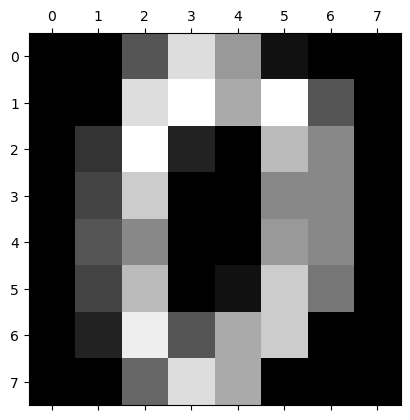

0


In [28]:
plt.gray()
plt.matshow(digits.images[0]) 
plt.show() 
print(digits.target[0])

###  Clasificación de dígitos escritos a mano con regresión logística (multiclase)

#### Ejercicio 6

Se pide aplicar regresión logística para obtener un clasificador para este problema multiclase. Probar con varios valores del parámetro `C` para obtener el mejor rendimiento sobre un conjunto de prueba. 

Algunas observaciones:

* Originalmente, en `digits.images` tenemos un array con 1797 arrays 8x8 (es decir, cada imagen viene en 64 pixeles distribuidos en 8 filas y 8 clolumnas). Para poder aplicar los clasificadores, cada imagen debe ser un vector de 64 componentes. Esto se consigue de manera sencilla con el método `reshape`de numpy. 
* Es necesario separar el conjunto de imágenes en entrenamiento y prueba. No olvidar hacerlo de manera estratificada (usando la opción `stratify`de `train_test_split`)
* Medir el rendimiento usando `score`. 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import accuracy_score

En este apartado lo que estoy haciendo es:

* obtener el conjunto de datos, las imagenes y las etiquetas(clasificación)

* también defino algunos valores de C como indica el enunciado para encontrar uno que maximice el rendimiento

* Voy entrenando para cada valor de este el modelo de regresión logística y comparando el rendimiento y el modelo, si es mejor lo almaceno como el mejor

* Finalmente me quedo el mejor y lo muestro

In [30]:
def best_model():    
    # Cargar el conjunto de datos de dígitos
    digits = datasets.load_digits()
    # Obtener las imágenes y las etiquetas del conjunto de digitos
    images = digits.images.reshape((len(digits.images), -1))
    labels = digits.target

    # Definimos múltiples valores de C aumentando la regulzarición para  probar con estos valores la regresión logística
    C_values = [0.001, 0.01, 0.1, 10, 50, 100]

    #Guardo en estas variables las variables que maximicen el rendimiento
    best_score = 0
    best_C = 0

    # Dividimos el conjunto de datos en entrenamiento pasandole las images y las etiquetas
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)


    for c in C_values:
        # Creamos y entrenamos el modelo de regresión para el valor correspondiente de C
        model = LogisticRegression(C=c, max_iter=10000, random_state=42)
        model.fit(X_train, y_train)

        # Medimos el rendimiento en el conjunto de prueba
        score = model.score(X_test, y_test)

        # Actualizar el mejor rendimiento y el mejor valor de C
        if score > best_score:
            best_score = score
            best_C = c
            best_model = model


    # Nos quedamos el mejor modelo
    
    score = best_model.score(X_test, y_test)
    
    y_pred = best_model.predict(X_test)

    print(f"El mejor valor de C es : {best_C}")
    print(f" El mejor rendimiento en el conjunto de prueba es: {score}")
    
    return best_model,y_pred
    
    

In [31]:
best_model()

El mejor valor de C es : 0.01
 El mejor rendimiento en el conjunto de prueba es: 0.9611111111111111


(LogisticRegression(C=0.01, max_iter=10000, random_state=42),
 array([5, 2, 8, 6, 7, 2, 6, 2, 6, 5, 0, 5, 9, 3, 4, 4, 2, 4, 4, 9, 6, 3,
        8, 1, 2, 5, 6, 0, 3, 4, 6, 7, 2, 6, 6, 6, 8, 5, 0, 9, 1, 7, 9, 6,
        5, 7, 5, 2, 7, 5, 0, 1, 5, 5, 3, 2, 4, 0, 0, 2, 7, 5, 6, 1, 3, 7,
        6, 5, 7, 0, 9, 0, 3, 8, 2, 5, 7, 2, 3, 5, 9, 3, 2, 7, 9, 6, 8, 1,
        0, 8, 2, 9, 4, 8, 1, 2, 7, 8, 4, 2, 6, 9, 3, 7, 3, 9, 6, 1, 1, 0,
        9, 2, 1, 6, 3, 4, 8, 7, 1, 0, 0, 4, 6, 5, 1, 2, 8, 1, 3, 0, 0, 8,
        6, 4, 3, 9, 3, 3, 3, 3, 4, 7, 0, 0, 1, 9, 5, 8, 1, 5, 0, 6, 6, 6,
        6, 1, 4, 7, 6, 7, 7, 8, 7, 3, 6, 5, 9, 0, 3, 8, 0, 9, 8, 1, 9, 5,
        9, 5, 8, 9, 9, 7, 9, 1, 9, 5, 4, 7, 3, 0, 4, 9, 7, 7, 5, 6, 5, 8,
        3, 4, 5, 4, 9, 2, 5, 5, 2, 1, 3, 8, 8, 9, 3, 6, 1, 0, 1, 4, 0, 5,
        5, 6, 6, 7, 4, 3, 8, 4, 8, 0, 7, 9, 2, 1, 4, 8, 4, 2, 4, 0, 0, 0,
        2, 6, 7, 0, 4, 5, 2, 2, 9, 0, 4, 6, 8, 2, 3, 9, 2, 3, 0, 6, 8, 7,
        1, 4, 4, 1, 1, 6, 3, 8, 1, 2, 5, 7, 8, 3, 

### Clasificación binaria usando regresión logística

#### Ejercicio 7

Una vez encontrado un buen clasificador para el problema multiclase, mostrar la matriz de confusión finalmente obtenida sobre el conjunto de prueba. También mostrar las imágenes de un par de dígitos respectivamente hayan sido bien y mal clasificados.  Usando `predict_proba` mostrar las predicciones que realiza el modelo sobre esos dos dígitos, y comentar los resultados. 

Deducir de la matriz de confusión un par de dígitos que en general cueste más trabajo distinguir entre sí, y extraer de los datos sólo las imágenes correspondientes a esos dos dígitos. Por ejemplo: si se observa que entre el 8 y el 9 hay más errores de predicción, habría que extraer todas las imágenes de ochos y nueves y crear un conjunto de datos con ellas.  

Crear a partir de esos datos extraidos,  conjuntos de entrenamiento y prueba para aprender con regresión logística un clasificador que sea "especialista" es distinguir un dígito del otro. Como antes, probar con varios valores del parámetro para intentar obtener un buen rendimiento sobre el conjunto de prueba.

**Nota**: para extraer los datos correspondiente a un dígito, aplicar selección condicional de numpy. Por ejemplo, con `digits.target==8` obtenemos un array booleano en el que están a `True` solo las posiciones de los ejemplos cuyo target es 8. Si tenemos un array `a`, entonces `a[digits.target ==8]` es el array en el que se han seleccionado sólo esas posiciones.  
`  

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

* Primero para representar la matriz de  confusión le paso el mejor valor de C que he obtenido en el apartaod anterior con el mejor modelo, que es un valor de C = 0.01

* Después para crear un clasificador especializado, me quedo con los elementos parecidos, que en este caso son los números 8 y 9 . Acto seguido creo un conjunto de entrenamiento para estos valores y con múltiples valores de c para calcular el óptimo (como hice en el apartado anterior).

* Finalmente calculo los rendimientos y me quedo el mejor


* Referencias:
    
    https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    
    https://www.jcchouinard.com/confusion-matrix-in-scikit-learn/

C:\Users\alarc\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


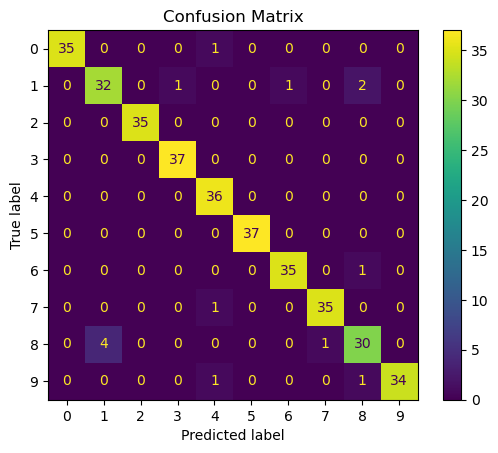

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

digits = datasets.load_digits()
# Obtener las imágenes y las etiquetas del conjunto de digitos
images = digits.images.reshape((len(digits.images), -1))
labels = digits.target
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)


# Entrenar el modelo de regresión logística
model = LogisticRegression(C=0.01, max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Visualizar la matriz de confusión
plot_confusion_matrix(model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

In [39]:
# Nos quedamos con indices de números parecidos
difficult_indices = np.where(np.isin(y_test, [8,9]))[0]

# Extraemos de estos las imágenes y etiquetas correspondientes
X_difficult = X_test[difficult_indices]
y_difficult = y_test[difficult_indices]
best_score=0

# Crear el conjunto de entrenamiento y de prueba para el clasificador
X_train_difficult, X_test_difficult, y_train_difficult, y_test_difficult = train_test_split(
    X_difficult, y_difficult, test_size=0.2, random_state=42, stratify=y_difficult)

# Múltiples valores de C
C = [0.001, 0.01, 0.1, 1, 10, 50]

for c in C:
    # Entrenamos un clasificador especializado para los valores dificiles con múltiples valores de C
    model = LogisticRegression(C=c, max_iter=10000, random_state=42)
    model.fit(X_train_difficult, y_train_difficult)

    # Calculamos el rendimiento
    score = model.score(X_test_difficult, y_test_difficult)
    
    #Actualizamos si es mejor y lo devolvemos al final
    if score > best_score:
        best_score = score
        
print(f"El rendimiento en el conjunto de prueba es : {best_score}")

El rendimiento en el conjunto de prueba es : 1.0


### Clasificación de dígitos con SVC (multiclase)

#### Ejercicio 8

Volviendo al problema multiclase de reconocimiento de dígitos, aplicar ahora máquinas de vectores soporte con kernel (`SVC`) para el problema de reconocer los dígitos. Probar al menos con varios valores de los parámetros `C` y `gamma`, para obtener un buen rendimiento sobre el conjunto de prueba. Explicar el papel que juegan esos dos parámetros. 

* En este último apartado tendremos que comprobar para SVC varios valores de C y Gamma para encontrar aquellos que maximicen el rendimiento

* C : Este atributo define la regularización, como  ya he dicho antes es inversamente proporcional, es decir, a mayor valor de C menor será la regularización y por lo tanto mayor de la probabilida de sobreajuste 

* Gamma: Con este valor especificamos la importancia de la distancia a cada ejemplo del conjunto, un valor de gamma más grande hace que el modelo sea más sensible

In [38]:
from sklearn.svm import SVC

# Definimos  valores a probar para los parámetros C y gamma
valores = {'C': [0.001, 0.01, 0.1, 10, 50], 'gamma': [0.001, 0.01, 0.1, 10, 100]}

# Inicializamos variables para almacenar el mejor rendimiento y los mejores parámetros
best_score = 0
best_params = {}

# Iteramos sobre los valores de C y gamma
for c in valores['C']:
    for g in valores['gamma']:
        # Creo y entreno el modelo 
        svm = SVC(kernel='rbf', C=c, gamma=g)
        
        svm.fit(X_train, y_train)

        # Realizo las predicciones en el conjunto de prueba
        y_pred = svm.predict(X_test)

        # Calculo el rendimiento
        score = accuracy_score(y_test, y_pred)

        # Actualizo los parámetros si se encuentra un modelo con mejor rendimiento
        if score > best_score:
            best_score = score
            params = {'C': c, 'gamma': g}

            
# Mostramos por pantalla los valores valor de C y Gamma en el svm, con el rendimiento que estos consiguen
print("Los parámetros que maximizan el rendimiento son C:" + str(params['C']) + " y un valor gamma de :" + str(params['gamma']))
print("Mejor rendimiento en el conjunto de prueba:", round(best_score, 2))

Los parámetros que maximizan el rendimiento son C:10 y un valor gamma de :0.001
Mejor rendimiento en el conjunto de prueba: 0.99
